In [1]:
import numpy
from collections import deque
import pandas
import math
import pandas_datareader.data as web
import datetime
import requests
import requests_cache
import xlrd
import tempfile
import itertools
import seaborn
from matplotlib import pyplot as plt

/Users/justus/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
seaborn.set(style='whitegrid')
seaborn.set_context('poster')

In [3]:
def shiller_date_converter(x):
    year = int(x)
    month = int(x * 100) - (year * 100)
    dx = datetime.date(year, month, 1)
    return dx

def get_shiller(url="http://www.econ.yale.edu/~shiller/data/ie_data.xls"):
    expire_after = datetime.timedelta(days=3)
    session = requests_cache.CachedSession(cache_name='data-cache', backend='sqlite', expire_after=expire_after)

    r = session.get(url, stream=True)

    with tempfile.NamedTemporaryFile(suffix='.xls') as tmp:
        for chunk in r.iter_content(chunk_size=1024):
            tmp.write(chunk)
            
        tmp.flush()

        df = pandas.read_excel(tmp.name,
                               sheet_name='Data',
                               engine='xlrd',
                               skiprows=7,
                               skipfooter=11, # WARN: is this always 11?
                               index_col=0,
                               usecols="A:E,G:K")
        df.rename(columns={'Price' : 'Real Price',
                          'Dividend' : 'Real Dividend',
                          'Earnings' : 'Real Earnings'}, inplace=True)
        # Convert from Shiller's wonky date format to a real one
        df.index = pandas.DatetimeIndex([shiller_date_converter(n) for n in df.index])
    return df

shiller = get_shiller()
shiller.head()

,P,D,E,CPI,Rate GS10,Real Price,Real Dividend,Price.1,Real Earnings
1871-01-01,4.44,0.26,0.4,12.464061,5.320000,91.846528,5.378400,91.846528,8.274462
1871-02-01,4.50,0.26,0.4,12.844641,5.323333,90.329556,5.219041,90.764476,8.029294
1871-03-01,4.61,0.26,0.4,13.034972,5.326667,91.186421,5.142835,92.056100,7.912054
1871-04-01,4.74,0.26,0.4,12.559226,5.330000,97.309400,5.337646,98.686522,8.211764
1871-05-01,4.86,0.26,0.4,12.273812,5.333333,102.093046,5.461768,103.999455,8.402720


In [12]:
def get_tr(returns):
    value = 1
    shares = None
    s = {}
    for date, row in returns.iterrows():
        if not shares:
            # first loop
            shares = value / row['P']
        else:
            dividend = row['D'] / 12 * shares
            shares += dividend / row['P']
            value = shares * row['P']
        s[date] = value
    return pandas.Series(s)

In [13]:
def get_price(returns):
    value = 1
    shares = None
    s = {}
    for date, row in returns.iterrows():
        if not shares:
            # first loop
            shares = value / row['P']
        else:
            dividend = row['D'] / 12 * shares
            value = shares * row['P']
        s[date] = value
    return pandas.Series(s)

In [14]:
def get_dividends(returns):
    value = 1
    shares = None
    s = {}
    for date, row in returns.iterrows():
        if not shares:
            # first loop
            shares = value / row['P']
        else:
            dividend = row['D'] / 12 * shares
            value += dividend
        s[date] = value
    return pandas.Series(s)

In [48]:
year = '1926'
r = shiller[year:]
total_return = get_tr(r)
price_only = get_price(r)
div_only = get_dividends(r)
df = pandas.DataFrame(data={'total returns': total_return, 'price only': price_only})#, 'dividends only': div_only})
#df = pandas.DataFrame(data={'total returns': total_return, 'price only': price_only, 'dividends only': div_only})
#df = pandas.DataFrame(data={'total returns': total_return, 'dividends only': div_only})

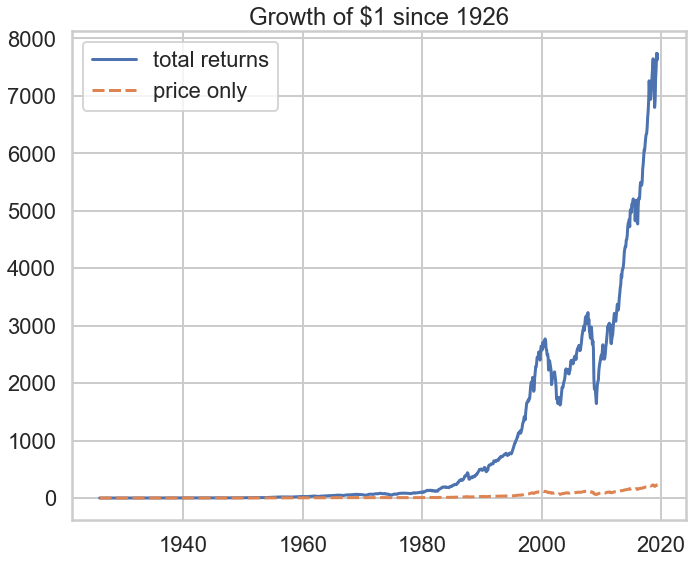

In [49]:
plt.figure(figsize=(11,9))
plt.title(f'Growth of $1 since {year}')
seaborn.lineplot(data=df)

In [54]:
def relative_contribution(returns):
    total_return = get_tr(returns)
    price_only = get_price(returns)
    return price_only[-1] / total_return[-1]

def relative_contribution_divs(returns):
    total_return = get_tr(returns)
    div_only = get_dividends(returns)
    return div_only[-1] / total_return[-1]

In [73]:
s = {}
length = 30
for i in range(shiller.index[0].year, shiller.index[-1].year - length):
    r = shiller[str(i):str(i+length)]
    s[i] = relative_contribution(r)
rc = pandas.Series(s)

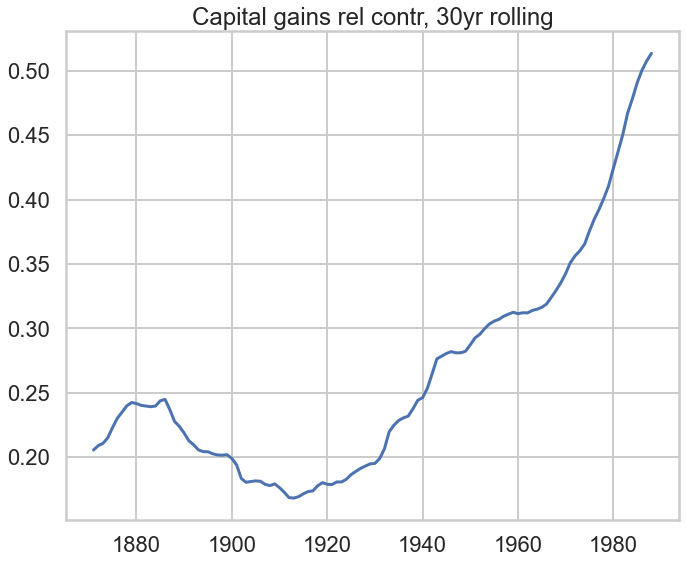

In [74]:
plt.figure(figsize=(11,9))
plt.title(f'Capital gains rel contr, {length}yr rolling')
seaborn.lineplot(data=rc)

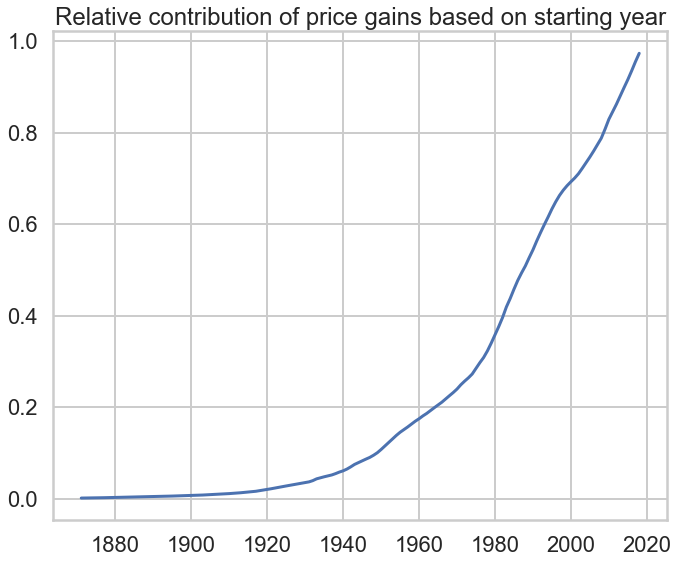

In [56]:
s = {}
length = 0
for i in range(shiller.index[0].year, shiller.index[-1].year - length):
    r = shiller[str(i):]
    s[i] = relative_contribution(r)
rc1 = pandas.Series(s)
plt.figure(figsize=(11,9))
plt.title('Relative contribution of price gains based on starting year')
seaborn.lineplot(data=rc1)

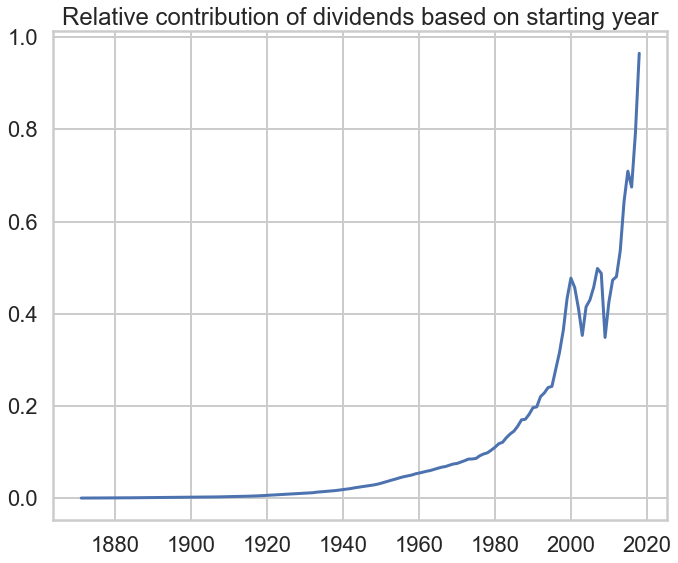

In [58]:
s = {}
length = 0
for i in range(shiller.index[0].year, shiller.index[-1].year - length):
    r = shiller[str(i):]
    s[i] = relative_contribution_divs(r)
rc2 = pandas.Series(s)
plt.figure(figsize=(11,9))
plt.title('Relative contribution of dividends based on starting year')
seaborn.lineplot(data=rc2)

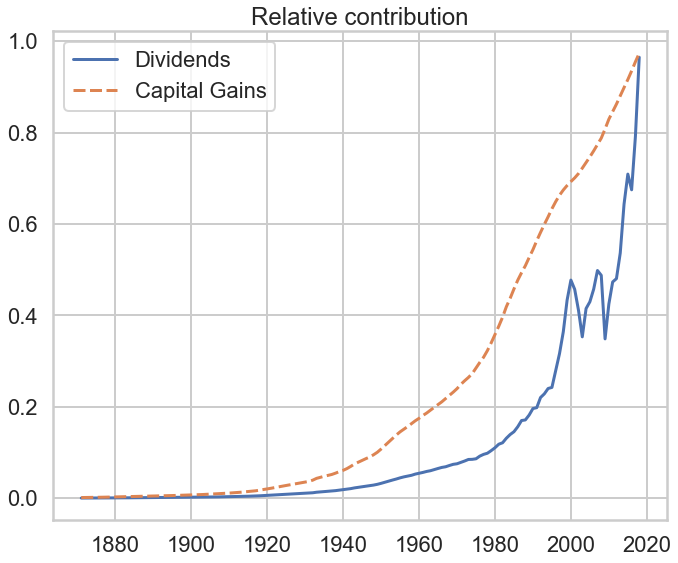

In [62]:
plt.figure(figsize=(11,9))
plt.title('Relative contribution')
df = pandas.DataFrame(data={'Dividends': rc2, 'Capital Gains': rc1})
seaborn.lineplot(data=df)